<a href="https://colab.research.google.com/github/krishnapatury/DataScience/blob/main/KrishnaPatury_Malaria_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Malaria Detection**

<b>Problem Definition</b>
**Context:**<br>
Malaria is a contagious disease caused by infected female Anopheles mosquitoes by parasites entering the blood and damaging red blood cells (RBCs) that carry oxygen. Late treatment can be fatal, with almost 50% of the world’s population in danger of malaria. In 2019, children accounted for 67% of all malaria deaths worldwide. 

Diagnosis in the laboratory depends heavily on human expertise in distinguishing infected cells from healthy cells and is time-consuming, and accuracy is affected by variability in manual classification. Automated tools might provide quicker and better results to help with early detection. 

<br>**Objectives:** <br>
Building an efficient computer vision model to identify whether a given image of a red blood cell is infected with malaria or not, and classify the same as parasitized or uninfected, respectively.

<br>**Key questions:** <br>
Given a set of images of both parasitized and uninfected cells, learning the differences between the two to accurately classify unseen images.

<br>**Problem formulation:**<br>
Achieve faster results and better accuracy in malaria classification by reducing variability due to manual intervention. 

## <br><b>Data Description </b>
There are a total of 24,958 train and 2,600 test images (colored) taken from microscopic images. These images are of the following categories:<br>


**Parasitized:** The parasitized cells contain the Plasmodium parasite which causes malaria<br>
**Uninfected:** The uninfected cells are free of the Plasmodium parasites<br>


<b> Mount the Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<b>Load libraries</b>

In [ ]:
# OpenCV to convert images from RGB to HSV
import cv2

# Kera libraries for building the deep learning models
from keras import backend
from keras.applications.vgg16 import VGG16
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, LeakyReLU
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

# For reading image files from directory
import os

# For numerical operations
import numpy as np

# For plotting graphs
import matplotlib.pyplot as plt

# For scientific operations and data manipulations
import pandas as pd

# For reading an image
from PIL import Image

# For randomizing data access
from random import shuffle
import random

# For visualizations
import seaborn as sns

# For splitting data for training and testing
from sklearn.model_selection import train_test_split
# For model evaluation
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# For displaying tabular data
from tabulate import tabulate
# For setting random seed to randomize in the same way for each execution
from tensorflow import random as tfr

# For accessing zipfile contents
import zipfile

<b>Load the data</b>

In [ ]:
# Extracts zip file
with zipfile.ZipFile('/content/drive/MyDrive/ADSP/DeepLearning/cell_images.zip', 'r') as zip_ref:
    zip_ref.extractall()

The extracted folder has different folders for train and test data containing images of different sizes for parasitized and uninfected cells within the respective folder name. 

The images need to be resized to be of same size, and converted to 4D arrays to be used as an input for the convolutional neural network. The train and test data also needs to be labeled (0-Uninfected and 1-Parasitized).

In [ ]:
# Size of image so that each image has the same size
IMG_SIZE = 64
# Label for parasitized images
PARASITIZED = 1
# Label for uninfected images
UNINFECTED = 0

# Reads the images from the path parameter, resizes the images, converts them to Numpy arrays, and
# creates labels based on the folder from which they are read(0 - uninfected, 1 - parasitized)
def getConvertedImages(path):

  # Dictionary to hold images and labels for training/test data
  data = dict(images = [], labels = [])

  # Run the same code for "parasitized" as well as "uninfected" folders
  for folder_name in ['/parasitized/', '/uninfected/']:
    
    # Path of the folder
    images_path = os.listdir(path + folder_name)

    for i, image_name in enumerate(images_path): 
      try:
      
          # Open each image using the path of that image
          image = Image.open(path + folder_name + image_name)

          # Resize each image to (64, 64)
          image = image.resize((IMG_SIZE, IMG_SIZE))

          # Convert images to arrays and append to input list
          data["images"].append(np.array(image))

          # Create labels for parasitized and uninfected images
          if folder_name == '/parasitized/':
              data["labels"].append(PARASITIZED)
          else:
              data["labels"].append(UNINFECTED)
        
      except Exception:
          pass       

  # Converting lists to arrays
  data["images"] = np.array(data["images"])
  data["labels"] = np.array(data["labels"])

  return data

<b> Read the training and test images and label them

In [ ]:
# Get the training data
train_data = getConvertedImages('/content/cell_images/train')

# Get the test data
test_data = getConvertedImages('/content/cell_images/test')

<b> Check the shapes of the training and test data

In [ ]:
# Shape of training images and labels
print("Shape of training images is", train_data["images"].shape, "and training labels is", train_data["labels"].shape)

# Shape of test images and labels
print("Shape of test images is", test_data["images"].shape, "and test labels is", test_data["labels"].shape)

Shape of training images is (24958, 64, 64, 3) and training labels is (24958,)
Shape of test images is (2600, 64, 64, 3) and test labels is (2600,)


There are 24958 images in the training data with each image of dimensions 64X64X3. The 3 channels indicate the images are color images. There are 2600 similar images in the testing data.


<b>Check the range of pixel values for train and test images

In [ ]:
print("The training images range from a min of", train_data["images"].min(), "to a max of", train_data["images"].max(), "pixels each.")
print("The test images range from a min of", test_data["images"].min(), "to a max of", test_data["images"].max(), "pixels each.")

The training images range from a min of 0 to a max of 255 pixels each.
The test images range from a min of 0 to a max of 255 pixels each.


Each image has 3 channels each represented between 0 anbd 255 pixels.



<b> Count the number of values in both uninfected and parasitized 

In [ ]:
#Converted to Pandas DataFrames to access value_counts()
train_labels = pd.DataFrame(data=train_data['labels'], columns=['is_infected'])
print("Counts for training data: \n", train_labels['is_infected'].value_counts(), "\n")

test_labels = pd.DataFrame(data=test_data['labels'], columns=['is_infected'])
print("Counts for test data: \n", test_labels['is_infected'].value_counts())

Counts for training data: 
 1    12582
0    12376
Name: is_infected, dtype: int64 

Counts for test data: 
 1    1300
0    1300
Name: is_infected, dtype: int64


<b>Normalize the images

In [ ]:
# As the image pixel values range from 0 - 255, we can simply divide all the 
# pixel values by 255 to standardize all the images to have values between 0 - 1.
train_data["images"] = train_data["images"].astype('float32')/255.0
test_data["images"] = test_data["images"].astype('float32')/255.0

There are 1,300 images with and without infections in the test data. The training data has slightly more parasitized images (12,582) compared to images without infections(12,376). Overall, the data can be considered balanced.

Plots to display balance of the data between parasitized and uninfected.

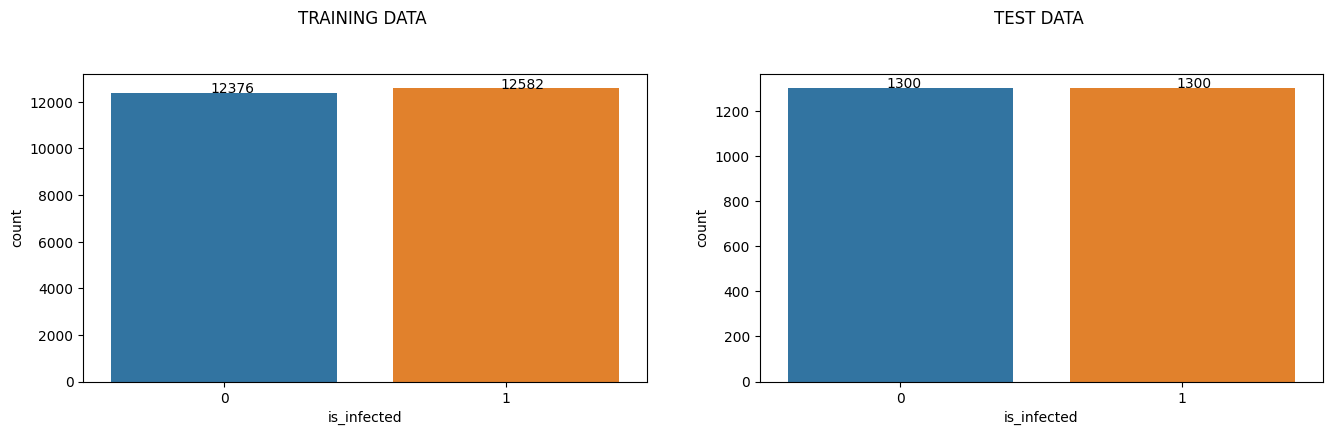

In [ ]:
# Count plot to visualize balance of data
plt.figure(figsize = (16, 4))

plt.subplot(1, 2, 1)
plt.title("TRAINING DATA \n\n")
# Labels on the bars with counts
plt.text(x=-0.05, y=train_labels['is_infected'].value_counts()[0]+2, s=train_labels['is_infected'].value_counts()[0])
plt.text(x=0.98, y=train_labels['is_infected'].value_counts()[1]+2, s=train_labels['is_infected'].value_counts()[1])
sns.countplot(x = 'is_infected', data = train_labels)

plt.subplot(1, 2, 2)
plt.title("TEST DATA \n\n")
plt.text(x=-0.05, y=test_labels['is_infected'].value_counts()[0]+2, s=test_labels['is_infected'].value_counts()[0])
plt.text(x=0.98, y=test_labels['is_infected'].value_counts()[1]+2, s=test_labels['is_infected'].value_counts()[1])
sns.countplot(x = 'is_infected', data = test_labels)

plt.show()

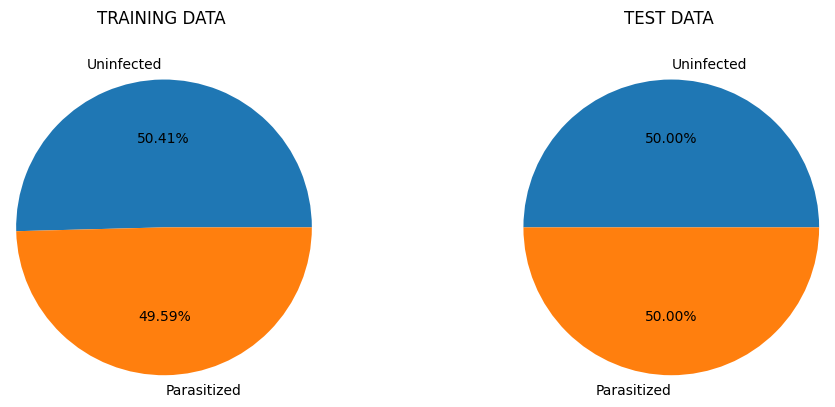

In [ ]:
# Pie plots too show distribution as a percentage
plt.figure(figsize = (12, 4))

plt.subplot(1, 2, 1)
plt.title("TRAINING DATA \n\n")
# 'autopct' displays the percentage upto 2 decimal place
plt.pie(train_labels.value_counts(), autopct = '%.2f%%', radius = 1.2, labels = ['Uninfected', 'Parasitized'])

plt.subplot(1, 2, 2)
plt.title("TEST DATA \n\n")
plt.pie(test_labels.value_counts(), autopct = '%.2f%%', radius = 1.2, labels = ['Uninfected', 'Parasitized'])

plt.show()

The data is pretty balanced across both datasets. So we can use the accuracy as a model evaluation metric. In this case, misclassifying a parasitized cell has more serious repurcussions than miclassifying an uninfected cell. Therefore, will also check the recall/sensitivity scores to evaluate the models.



<b>Data Exploration</b>
Visualizing the parasitized and uninfected images in the train and test data to understand the similarities and differences better.

In [ ]:
# Visualizing the parasitized and uninfected images in the train and test data
def visualiseData(data):
  
  # To get the same images each time the code is run
  np.random.seed(42)

  plt.figure(1, figsize = (12 , 12))
  for n in range(1, 37):
      plt.subplot(6, 6, n)
      index = int(np.random.randint(0, data["images"].shape[0], 1))
      plt.title((lambda imgtype : "Parasitized" if imgtype ==  PARASITIZED else "Uninfected") (data["labels"][index]))
      plt.imshow(data["images"][index])
      plt.axis('off')

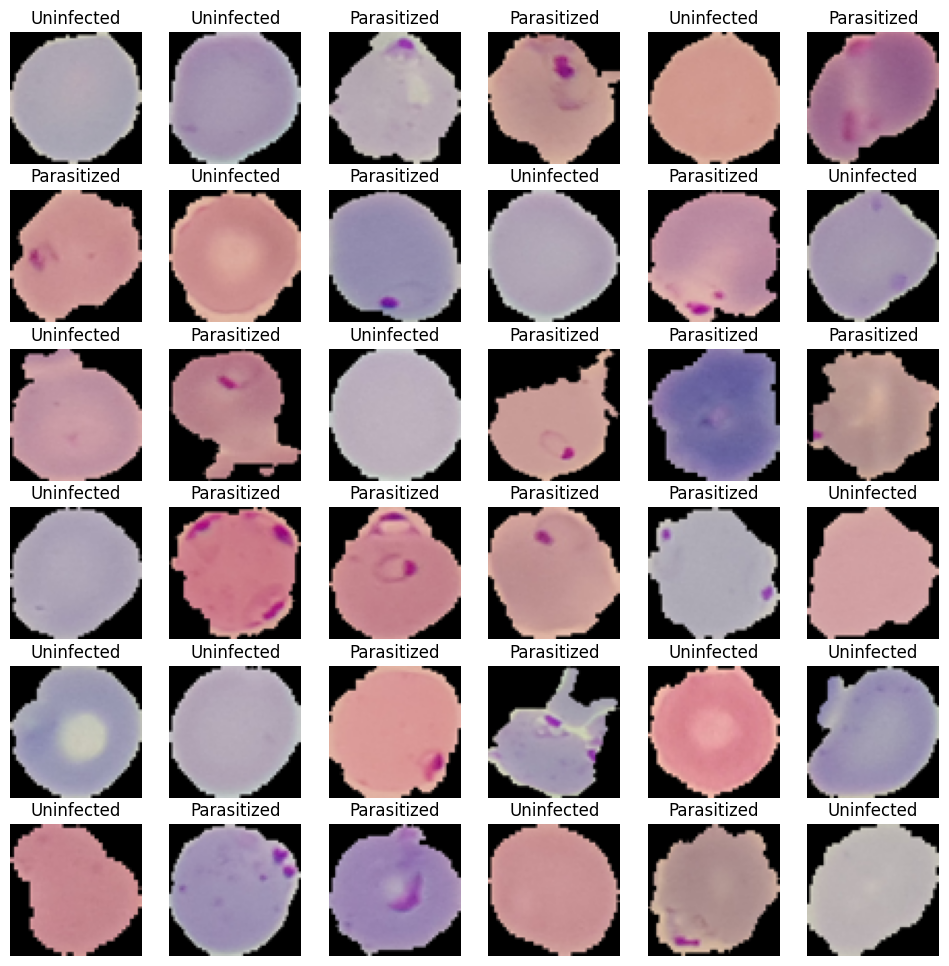

In [ ]:
visualiseData(train_data)

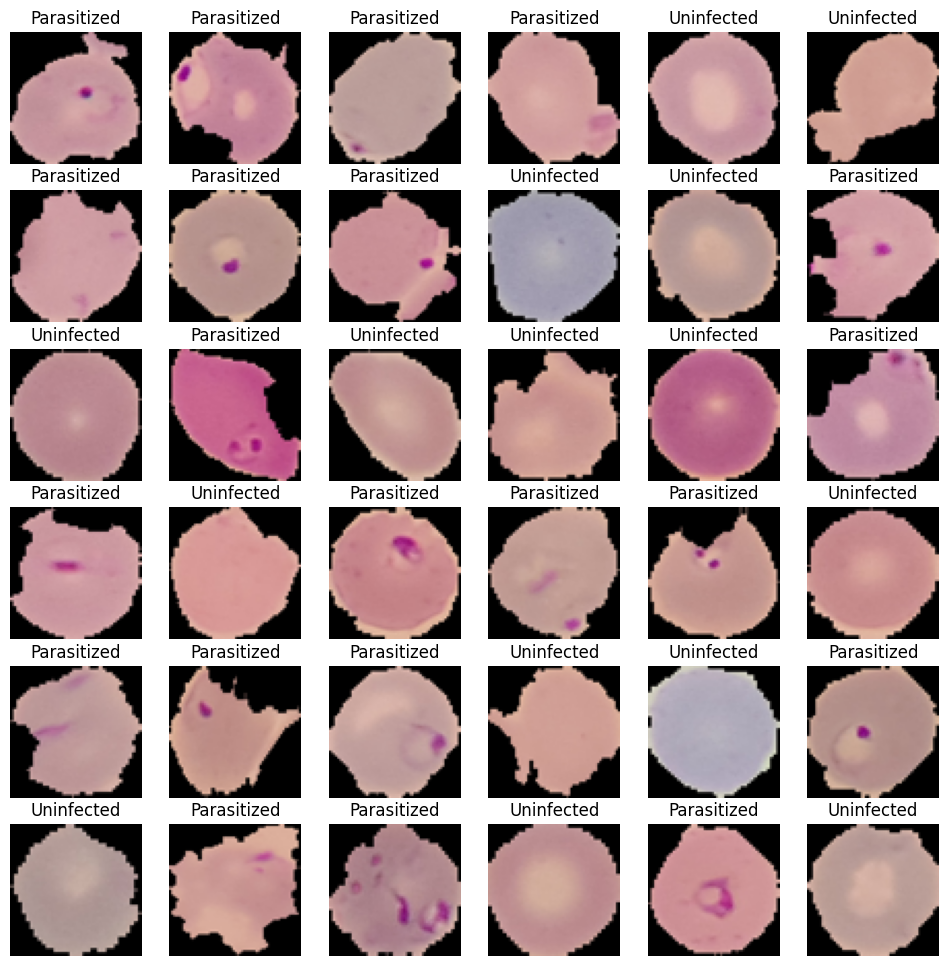

In [ ]:
visualiseData(test_data)

The infected images have a visible coloration in different areas of the image. The uninfected ones are more or less a single shade. Sometimes, both images seem to have a center in a different shade. The infected markings have to be fairly dark in intensity to be considered parasitized. They also seem to be mostly at the periphery of the cells altough this is not always true( ex: 27th image in the test data).

Plotting the mean images for parasitized and uninfected

In [ ]:
# Function to plot the mean image
def plotMeanImg(data, imgtype):

  imgLabel = (lambda x : "Parasitized" if x ==  PARASITIZED else "Uninfected") (imgtype)

  relevant_data = []
  for index, label in np.ndenumerate(data["labels"]):
    if label == imgtype:
      relevant_data.append([data["images"][index]]) 

  print("\nNumber of ",  imgLabel, " images: ", len(relevant_data), "\n")
  images = np.array(relevant_data)
  
  # Calculate the average
  averageImg = np.mean(images, axis = 0)[0]

  # Reshape it back to a matrix
  plt.imshow(averageImg)
  plt.title("Average " + imgLabel)
  plt.axis('off')
  plt.show()

<b> Mean for parasitized and uninfected images


Number of  Parasitized  images:  12582 



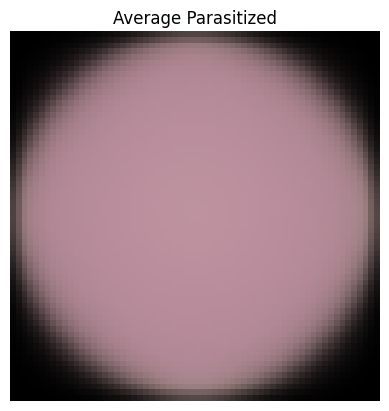


Number of  Uninfected  images:  12376 



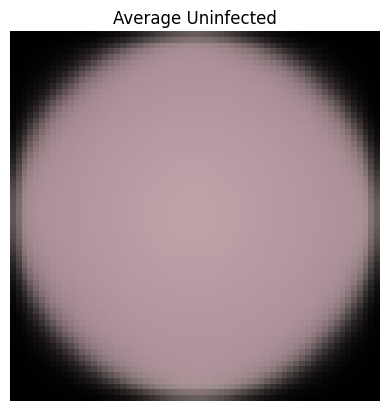

In [ ]:
plotMeanImg(train_data, PARASITIZED)
plotMeanImg(train_data, UNINFECTED)

The uninfected images on average seem to be paler than the infected ones in intensity. This makes sense as they parasitized ones have high intensity colorations representing the infections. 

<b>Converting RGB to HSV of Images using OpenCV

In [ ]:
def plotHSVImages(data):

  # Convert RGB images to HSV(Hue Saturation Value) images
  hsvImages=[]   
  for i in np.arange(0, 100, 1):
    hsvImages.append(cv2.cvtColor(data["images"][i], cv2.COLOR_BGR2HSV))

  hsvImages = np.array(hsvImages)

  # Plotting 5 random images from the dataset
  viewimage = np.random.randint(1, 100, 5)
  fig, ax = plt.subplots(1, 5, figsize = (18, 18))

  for t, i in zip(range(5), viewimage):
    ax[t].set_title((lambda label : "Parasitized" if label ==  PARASITIZED else "Uninfected") (data["labels"][i]))
    #ax[t].imshow(hsvImages[i])
    # Removed normalization to address matplotlib warning
    #"WARNING:matplotlib.image:Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers)."
    ax[t].imshow((hsvImages[i]*255).astype(np.uint8))
    ax[t].set_axis_off()
    fig.tight_layout()

<b> Plot the training data

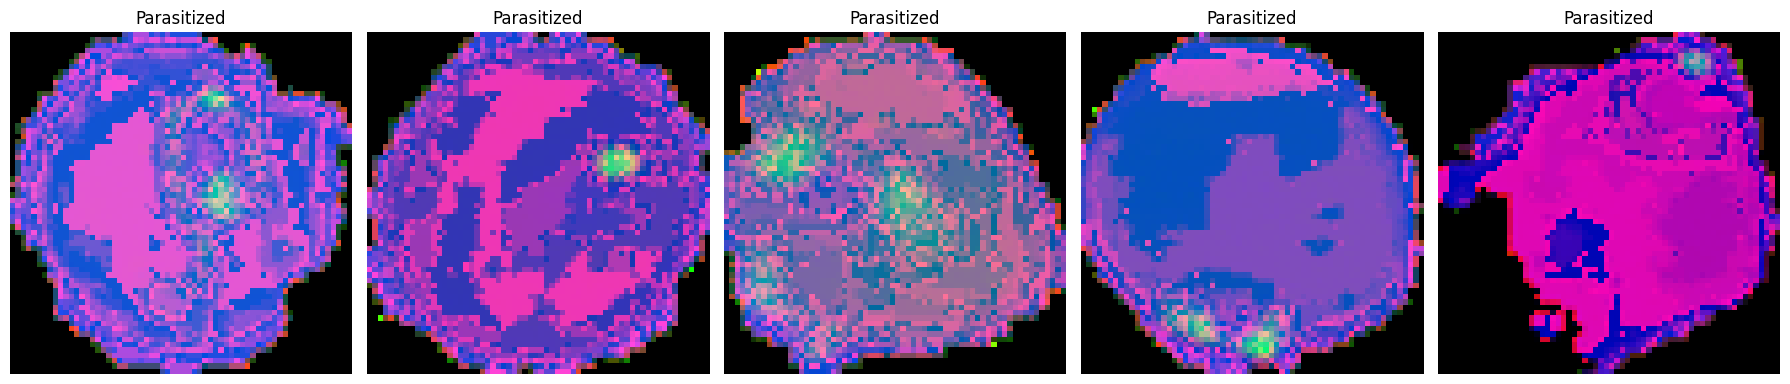

In [ ]:
#Plot training data
plotHSVImages(train_data)

<b> Plot the test data

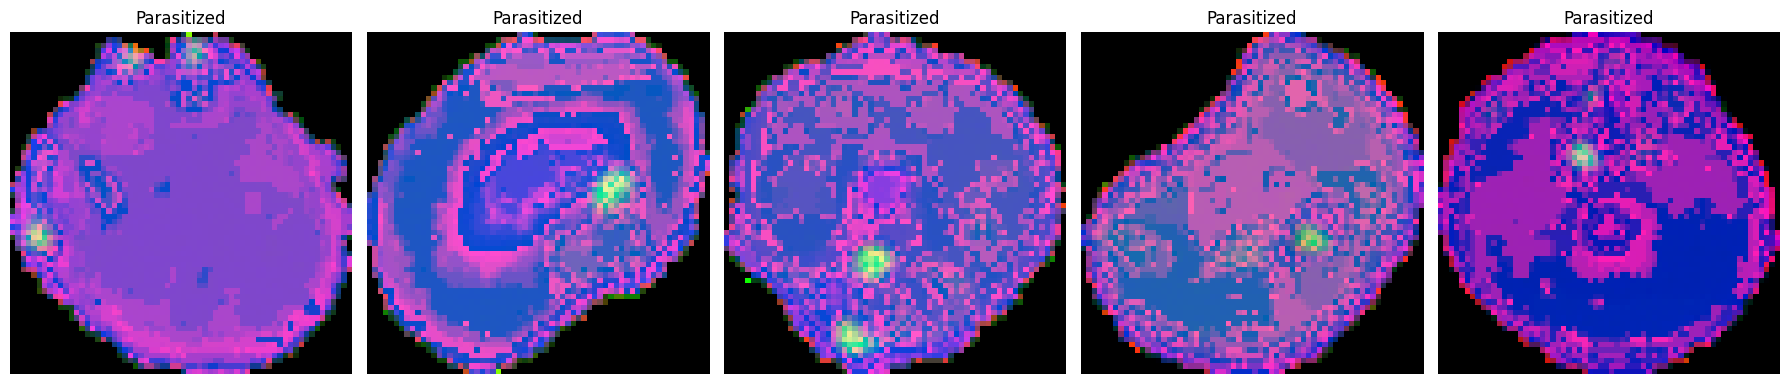

In [ ]:
#Plot training data
plotHSVImages(test_data)

It seems slightly more difficult to identify infections in the HSV model. It looks much better with the normalized data. Overall, there seems to be a lot more noise in the HSV images.

<b> Processing Images using Gaussian Blurring

In [ ]:
def applyGaussianBlurring(data):

  # To hold the blurred images
  gbx = []  
  for i in np.arange(0, 100, 1):
    gbx.append(cv2.GaussianBlur(data["images"][i], (5, 5), 0))
  gbx = np.array(gbx)

  viewimage = np.random.randint(1, 100, 5)
  fig, ax = plt.subplots(1, 5, figsize = (18, 18))
  for t, i in zip(range(5), viewimage):
    ax[t].set_title((lambda label : "Parasitized" if label ==  PARASITIZED else "Uninfected") (data["labels"][i]))
    ax[t].imshow(gbx[i])
    ax[t].set_axis_off()
    fig.tight_layout()

<b> Gaussian Blurring on train data

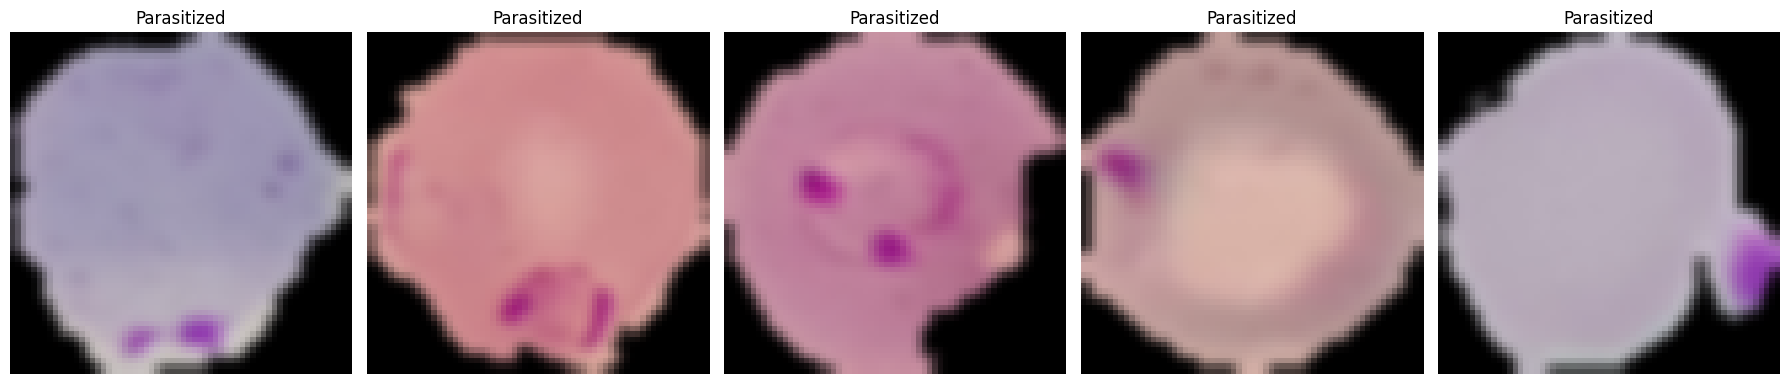

In [ ]:
#Gaussian Blurring on train data
applyGaussianBlurring(train_data)

<b> Gaussian Blurring on test data

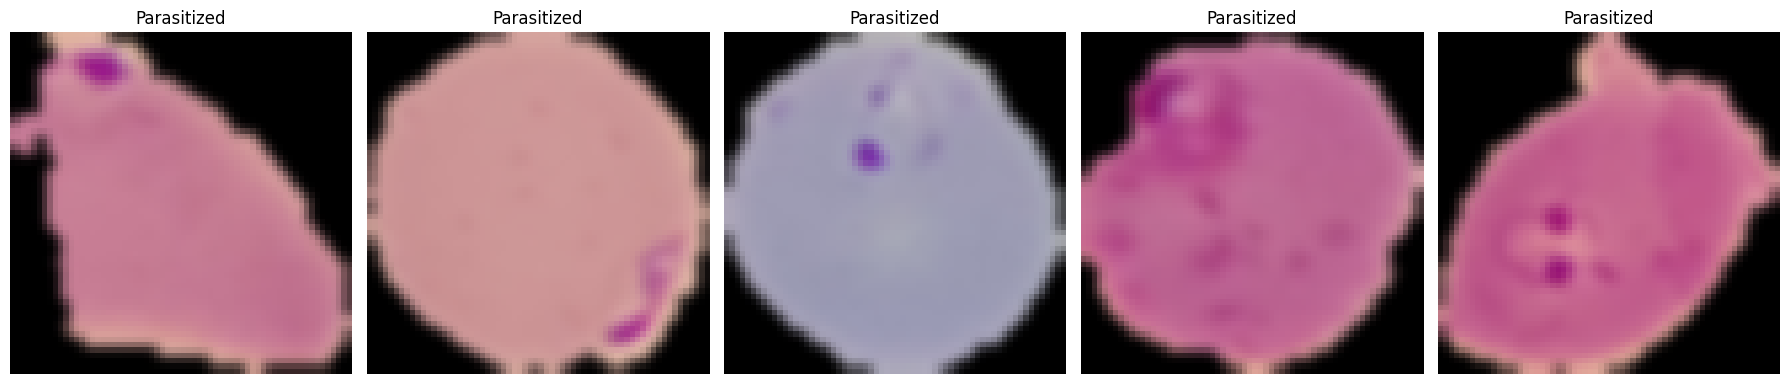

In [ ]:
# Gaussian Blurring on test data
applyGaussianBlurring(test_data)

Blurring seems to help the human eye but I wonder if this would cause some of the parasitized images to be considered as uninfected. 

## **Model Building**

Custom methods for building and evaluating the Models

In [ ]:
def softreset():
  '''
  Function to clear out previous model's history and fix random seeds to get same results for each run
  '''
  # Clearing backend
  backend.clear_session()

  # By setting the seed for random number generators in Numpy, the Random library in Python, 
  # and in TensorFlow, we can reproduce same results every time we run the code.
  np.random.seed(42)
  random.seed(42)
  tfr.set_seed(42)


def printMetrics(actual, predicted):
  '''
  Function to generate a classification report and plot the heatmap using 
  the confusion matrix. Takes the actual and predicted values as input.
  '''

  # Each entry of the target variable is a one-hot encoded vector. 
  # To print the classification report and confusion matrix, convert each entry to a single label.
  predicted_value = np.argmax(predicted, axis = 1)
  actual_value = np.argmax(actual, axis = 1)

  # Printing the classification report
  print(classification_report(actual_value, predicted_value))

  # Plotting the heatmap using confusion matrix
  cm = confusion_matrix(actual_value, predicted_value)     
  plt.figure(figsize = (8, 5))
  sns.heatmap(cm, annot = True,  fmt = '.0f', 
              xticklabels = ['Uninfected', 'Parasitized'], 
              yticklabels = ['Uninfected', 'Parasitized'])
  plt.ylabel('Actual')
  plt.xlabel('Predicted')
  plt.show()


def accuracyPlot(model_hist):
  '''
  Function to plot the validation and training accuracies. 
  Takes model history as input.
  '''

  dict_hist = model_hist.history
  nepochs = len(dict_hist['accuracy'])
  list_ep = [i for i in range(1, nepochs+1)]

  plt.figure(figsize = (8, 8))
  plt.title("Accuracy vs Epoch Plot")
  plt.plot(list_ep, dict_hist['accuracy'], ls = '--', label = 'accuracy')
  plt.plot(list_ep, dict_hist['val_accuracy'], ls = '--', label = 'val_accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epochs')
  plt.legend(loc="upper right")
  plt.show()



def modelsAccuracies():
  '''
  Function to print model accuracy on test data for all the models built
  '''
  table = [['Model Details', 'Accuracy'], 
           ['Model1: Base Model', accuracy1[1] ],
           ['Model2: With more Convolutions, Dropouts and relu', accuracy2[1]],
           ['Model3: With Batch Normalization and LeakyRelu', accuracy3[1]],
           ['Model4: With Data Augmentation', accuracy4[1]],
           ['Model5: Using transfer learning Pre-trained VGG16 model', accuracy5[1]]]
  
  print(tabulate(table, headers='firstrow'))

## <b>MODEL1 - Base Model

In [ ]:
# Clear Keras backend
softreset()

<B>One Hot Encoding the train and test labels</b>

There are two classes into each image will be classified, parasitized(1) and uninfected(0). 

In [ ]:
# Encoding Training Labels
train_data["labels"] = to_categorical(train_data["labels"], num_classes=2)

# Encoding Test Labels
test_data["labels"] = to_categorical(test_data["labels"], num_classes=2)

<b> Building the base model

In [ ]:
# Creating sequential model
model1 = Sequential()

model1.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu", input_shape = (64, 64, 3)))
model1.add(MaxPooling2D(pool_size = 2))
model1.add(Dropout(0.2))

model1.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu"))
model1.add(MaxPooling2D(pool_size = 2))
model1.add(Dropout(0.2))

model1.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu"))
model1.add(MaxPooling2D(pool_size = 2))
model1.add(Dropout(0.2))

model1.add(Flatten())

model1.add(Dense(512, activation = "relu"))
model1.add(Dropout(0.4))

# Output layer, using softmax activator for 2 class classification
model1.add(Dense(2, activation = "softmax")) 

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0

<b> Compiling the model

In [ ]:
model1.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

<b> Using Callbacks 

In [ ]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

<b> Fit and train the Model

In [ ]:
# Fit the model with min batch size as 32 so can tune batch size to a factor of 2^power ] 
model1_history = model1.fit(train_data["images"], train_data["labels"], batch_size = 32, callbacks = callbacks, 
                    validation_split = 0.2, epochs = 10, verbose = 1)

Epoch 1/10
624/624 [==============================] - 16s 8ms/step - loss: 0.3704 - accuracy: 0.8250 - val_loss: 0.1952 - val_accuracy: 0.9367
Epoch 2/10
624/624 [==============================] - 4s 7ms/step - loss: 0.1221 - accuracy: 0.9567 - val_loss: 0.0876 - val_accuracy: 0.9880
Epoch 3/10
624/624 [==============================] - 5s 8ms/step - loss: 0.0926 - accuracy: 0.9702 - val_loss: 0.0701 - val_accuracy: 0.9878
Epoch 4/10
624/624 [==============================] - 4s 7ms/step - loss: 0.0799 - accuracy: 0.9731 - val_loss: 0.0759 - val_accuracy: 0.9842
Epoch 5/10
624/624 [==============================] - 5s 7ms/step - loss: 0.0739 - accuracy: 0.9746 - val_loss: 0.0537 - val_accuracy: 0.9868
Epoch 6/10
624/624 [==============================] - 5s 8ms/step - loss: 0.0704 - accuracy: 0.9762 - val_loss: 0.0750 - val_accuracy: 0.9816
Epoch 7/10
624/624 [==============================] - 4s 7ms/step - loss: 0.0656 - accuracy: 0.9778 - val_loss: 0.0828 - val_accuracy: 0.9820


<b> Evaluating the model on test data

In [ ]:
accuracy1 = model1.evaluate(test_data["images"], test_data["labels"], verbose = 1)
print('\n', 'Accuracy on test data: ', accuracy1[1])

82/82 [==============================] - 0s 4ms/step - loss: 0.0716 - accuracy: 0.9781

 Accuracy on test data:  0.9780769348144531


<b> Plotting the confusion matrix

82/82 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1300
           1       0.98      0.97      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



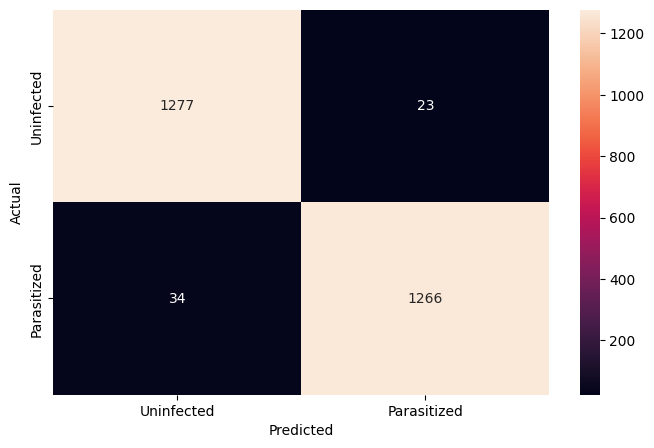

In [ ]:
predicted = model1.predict(test_data["images"])
printMetrics(test_data["labels"], predicted)

<b>Plotting the train and validation curves

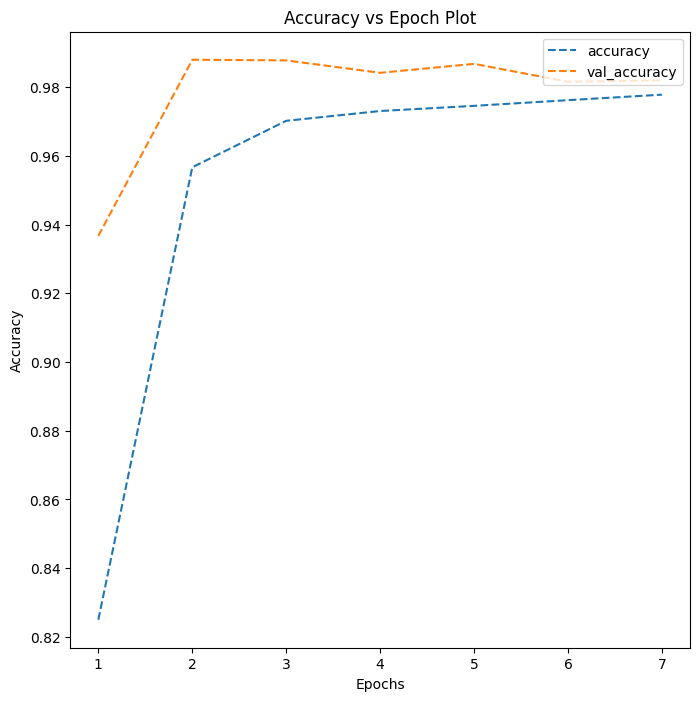

In [ ]:
accuracyPlot(model1_history)

Both validation and testing accuracy increased well before plateauing at .98. The model seemed to have generalized well.

##<b> MODEL2 - With more convolution layers and dropouts</b>
Building another model by adding more convolution filters, layers and increasing dropouts to try to improve the performance.

In [ ]:
# Clear Keras backend
softreset()

<b> Building the Model

In [ ]:
def model2():
  # Creating sequential model
  model = Sequential()

  model.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu", input_shape = (64, 64, 3)))
  model.add(MaxPooling2D(pool_size = 2))
  model.add(Dropout(0.3))

  model.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu"))
  model.add(MaxPooling2D(pool_size = 2))
  model.add(Dropout(0.3))

  model.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", activation = "relu"))
  model.add(MaxPooling2D(pool_size = 2))
  model.add(Dropout(0.5))

  model.add(Flatten())

  model.add(Dense(512, activation = "relu"))
  model.add(Dropout(0.4))

  # Output layer
  model.add(Dense(2, activation = "softmax")) 
  
  return model

model2 = model2()
model2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        4128      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 16, 16, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 16, 16, 32)        0

<b> Compiling the model

In [ ]:
model2.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])

<b> Using Callbacks

In [ ]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

<b>Fit and Train the model

In [ ]:
# Increasing the batch size to 64, leaving epochs as 10 as it stopped sooner before.
model2_history = model2.fit(train_data["images"], train_data["labels"], batch_size = 64, callbacks = callbacks, 
                    validation_split = 0.2, epochs = 10, verbose = 1)

Epoch 1/10
312/312 [==============================] - 6s 17ms/step - loss: 0.5358 - accuracy: 0.7275 - val_loss: 0.2463 - val_accuracy: 0.9219
Epoch 2/10
312/312 [==============================] - 3s 11ms/step - loss: 0.1525 - accuracy: 0.9405 - val_loss: 0.2436 - val_accuracy: 0.8844
Epoch 3/10
312/312 [==============================] - 3s 10ms/step - loss: 0.1291 - accuracy: 0.9516 - val_loss: 0.1294 - val_accuracy: 0.9619
Epoch 4/10
312/312 [==============================] - 4s 12ms/step - loss: 0.1181 - accuracy: 0.9603 - val_loss: 0.1437 - val_accuracy: 0.9788
Epoch 5/10
312/312 [==============================] - 3s 11ms/step - loss: 0.1090 - accuracy: 0.9641 - val_loss: 0.1273 - val_accuracy: 0.9810
Epoch 6/10
312/312 [==============================] - 3s 11ms/step - loss: 0.1069 - accuracy: 0.9676 - val_loss: 0.0822 - val_accuracy: 0.9880
Epoch 7/10
312/312 [==============================] - 3s 10ms/step - loss: 0.0947 - accuracy: 0.9697 - val_loss: 0.0870 - val_accuracy: 0.9872

<b> Evaluating the model

In [ ]:
accuracy2 = model2.evaluate(test_data["images"], test_data["labels"],  verbose = 1)
print('\n', 'Accuracy on test data: ', accuracy2[1])

82/82 [==============================] - 1s 4ms/step - loss: 0.0974 - accuracy: 0.9773

 Accuracy on test data:  0.9773076772689819


<b> Plotting the confusion matrix

82/82 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      1300
           1       0.97      0.98      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



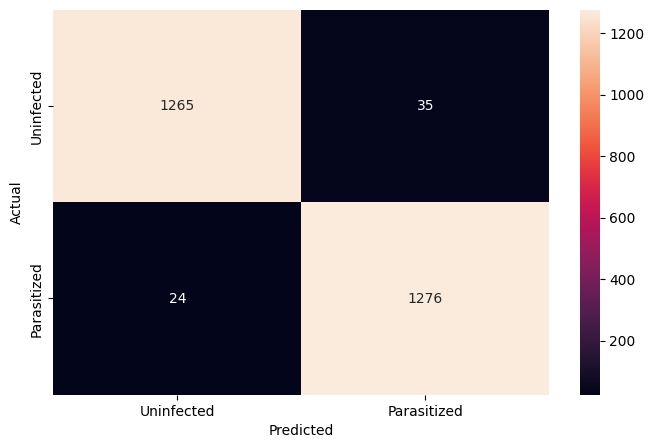

In [ ]:
predicted_model2 = model2.predict(test_data["images"])
printMetrics(test_data["labels"], predicted_model2)

<b> Plotting the train and the validation curves

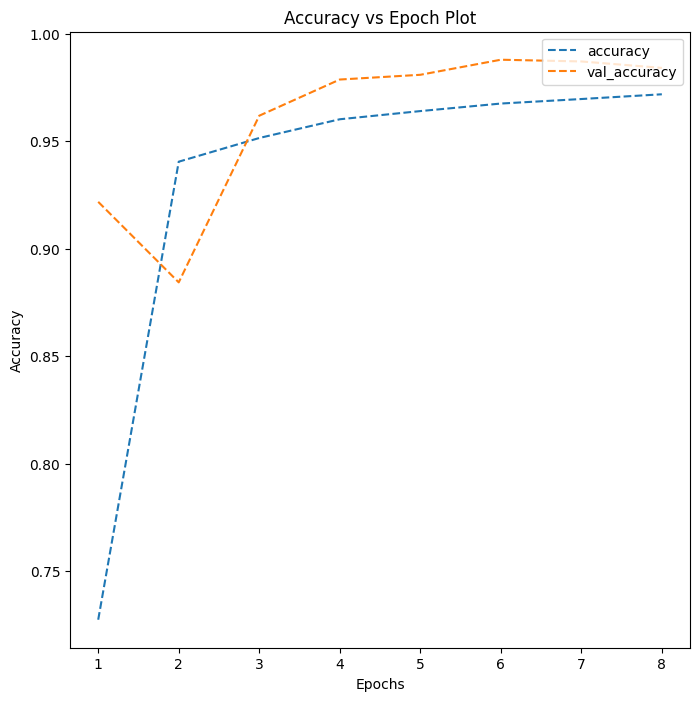

In [ ]:
accuracyPlot(model2_history)

##<b> MODEL3 - With Batch Normalization </b>

There was a slight improvement from the base model, built another model using BatchNormalization and using LeakyRelu as the activation function.

In [ ]:
# Clear Keras backend
softreset()

<b> Building the Model

In [ ]:
def model3():
  # Creating sequential model
  model = Sequential()

  model.add(Conv2D(filters = 32, kernel_size = 2, padding = "same", input_shape = (64, 64, 3)))
  model.add(LeakyReLU(0.1))
  model.add(MaxPooling2D(pool_size = 2))
  model.add(BatchNormalization())
  model.add(Dropout(0.3))

  model.add(Conv2D(filters = 64, kernel_size = 2, padding = "same"))
  model.add(LeakyReLU(0.1))
  model.add(MaxPooling2D(pool_size = 2))
  model.add(BatchNormalization())

  model.add(Conv2D(filters = 32, kernel_size = 2, padding = "same"))
  model.add(LeakyReLU(0.1))
  model.add(MaxPooling2D(pool_size = 2))
  model.add(BatchNormalization())

  model.add(Dropout(0.5))

  model.add(Flatten())

  model.add(Dense(128))
  model.add(LeakyReLU(0.1))
  model.add(Dropout(0.5))

  # Output layer
  model.add(Dense(2, activation = "softmax")) 
  
  return model

model3 = model3()
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        416       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 32)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 32, 32, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        8

<b>Compiling the model

In [ ]:
model3.compile(loss = 'categorical_crossentropy', optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])

<b> Using callbacks

In [ ]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

<b>Fit and train the model

In [ ]:
# Kept the batch size of 64, leaving epochs as 10 as it stopped sooner before.
model3_history = model3.fit(train_data["images"], train_data["labels"], batch_size = 64, callbacks = callbacks, 
                    validation_split = 0.2, epochs = 10, verbose = 1)

Epoch 1/10
312/312 [==============================] - 6s 18ms/step - loss: 0.6232 - accuracy: 0.6923 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 2/10
312/312 [==============================] - 5s 15ms/step - loss: 0.2454 - accuracy: 0.9007 - val_loss: 1.0574 - val_accuracy: 0.7067
Epoch 3/10
312/312 [==============================] - 4s 14ms/step - loss: 0.1382 - accuracy: 0.9505 - val_loss: 0.2777 - val_accuracy: 0.9219


<b>Plotting the train and validation accuracy

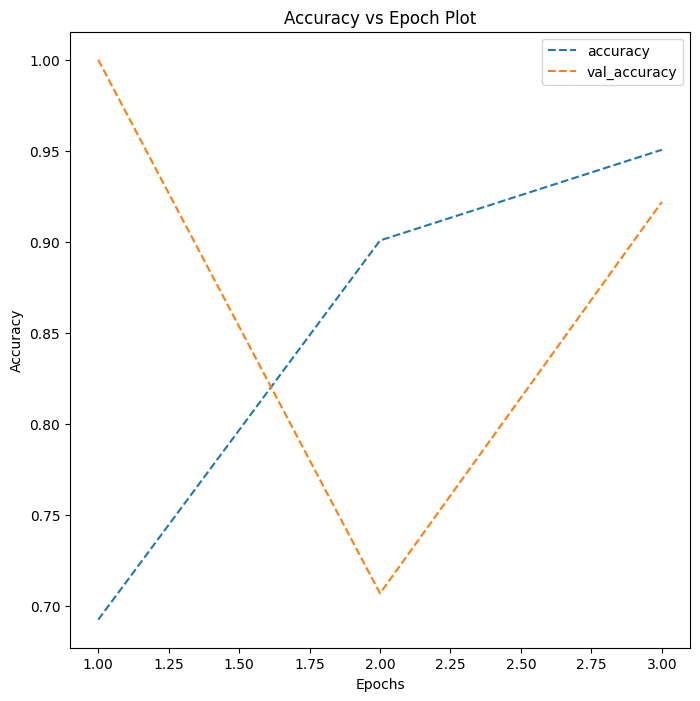

In [ ]:
accuracyPlot(model3_history)

<b>Evaluating the model

In [ ]:
accuracy3 = model3.evaluate(test_data["images"], test_data["labels"],  verbose = 1)
print('Model 3 Accuracy on test data: ', accuracy3[1])

82/82 [==============================] - 1s 4ms/step - loss: 0.2612 - accuracy: 0.9088
Model 3 Accuracy on test data:  0.9088461399078369


The accuracy on the validation data started at 1.00 and kept falling till the model was early stopped. The training accuracy steadily increased. 

<b> Generate the classification report and confusion matrix 

82/82 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.82      0.90      1300
           1       0.85      0.99      0.92      1300

    accuracy                           0.91      2600
   macro avg       0.92      0.91      0.91      2600
weighted avg       0.92      0.91      0.91      2600



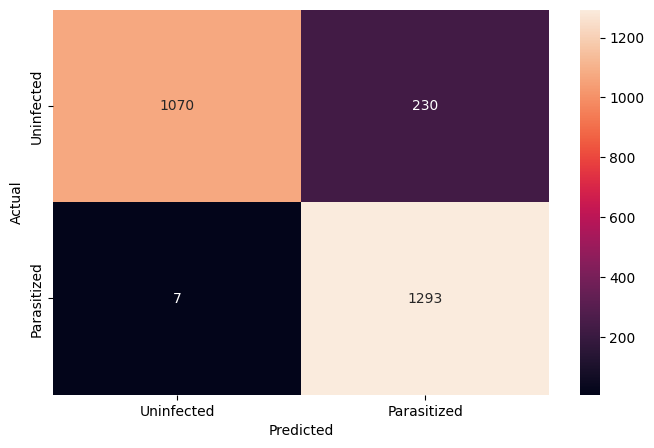

In [ ]:
predicted_model3 = model3.predict(test_data["images"])
printMetrics(test_data["labels"], predicted_model3)

##<b>MODEL4 - With Data Augmentation </b>

Will apply data augmentation to see if it helps improve the model (applied only against training and validation data, not against test data).

In [ ]:
# Clear Keras backend
softreset()

<b> Use image data generator

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_data["images"], 
                                                  train_data["labels"], 
                                                  test_size = 0.2, 
                                                  random_state = 42)

# Using ImageDataGenerator to generate images
train_datagen = ImageDataGenerator(horizontal_flip = True, 
                                   zoom_range = 0.1, 
                                   shear_range = 0.1,
                                   rotation_range = 20,
                                   height_shift_range= 0.1, 
                                   width_shift_range=0.1)

# Flowing training images using train_datagen generator
train_generator = train_datagen.flow(x = train_data["images"], 
                                     y = train_data["labels"], 
                                     batch_size = 64, 
                                     seed = 42, shuffle = True)


# Flowing validation images using val_datagen generator
val_generator =  ImageDataGenerator().flow(x = train_data["images"], 
                                           y = train_data["labels"],
                                           batch_size = 64, 
                                           seed = 42, shuffle = True)

<B>Visualizing Augmented images

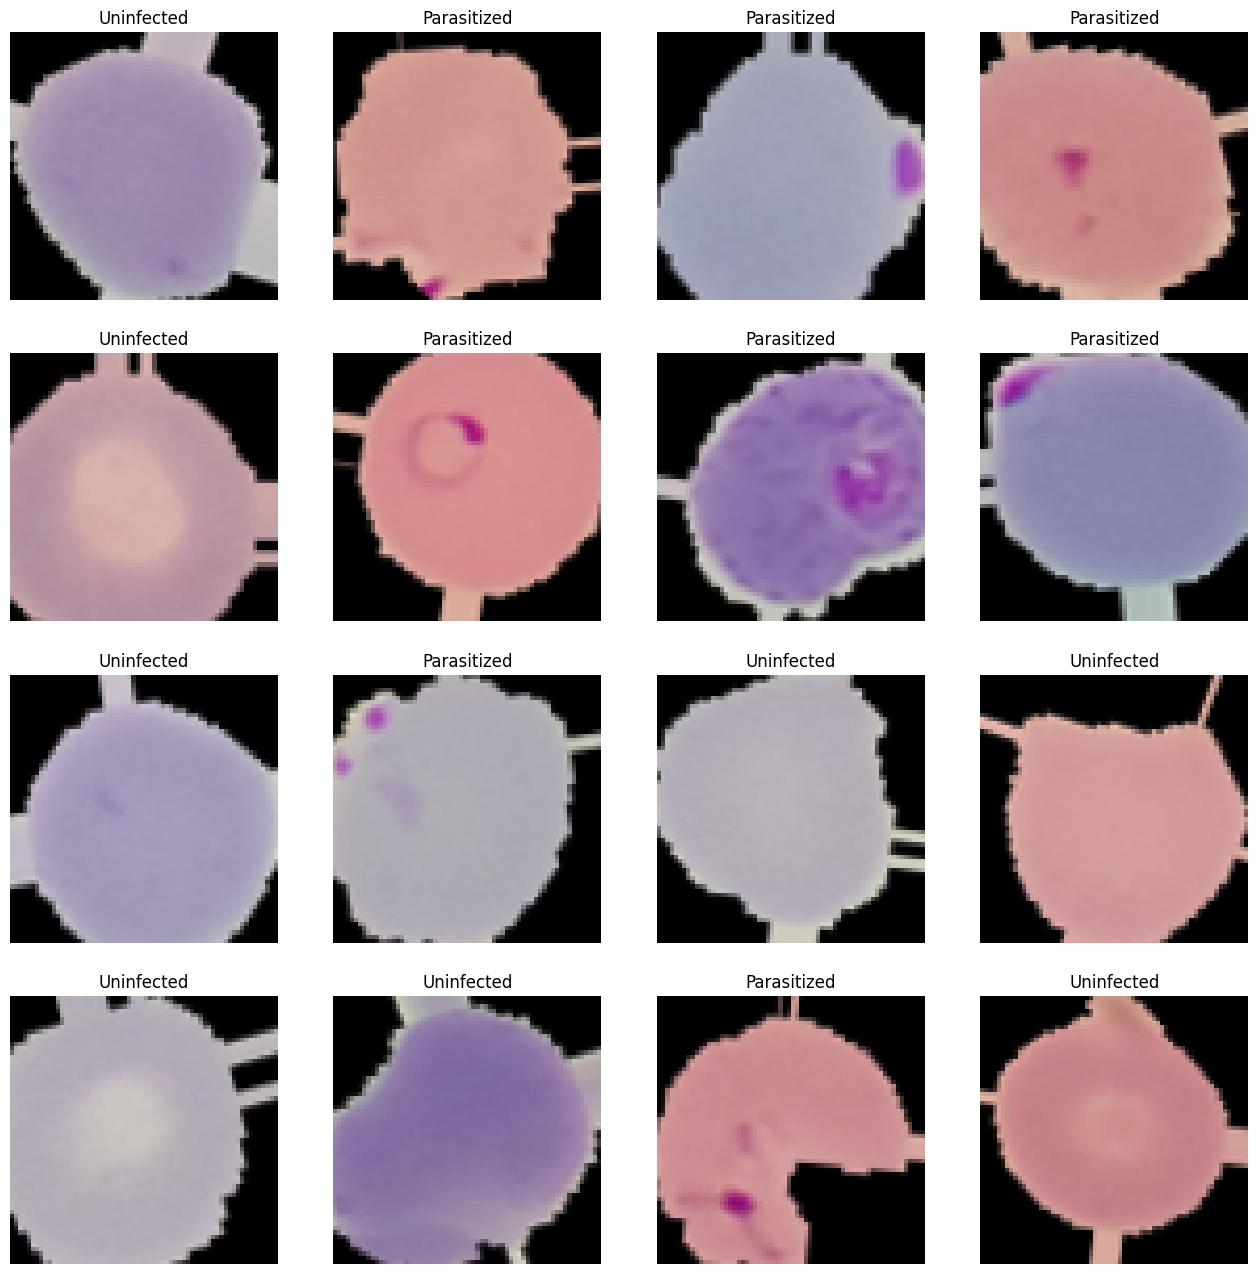

In [ ]:
def visualizeAugmentedImgs(train_generator):

  images, labels = next(train_generator)
  fig, axes = plt.subplots(4, 4, figsize = (16, 8))
  fig.set_size_inches(16, 16)

  for (image, label, ax) in zip(images, labels, axes.flatten()):
    ax.imshow(image)
    ax.set_title((lambda x : "Parasitized" if x ==  PARASITIZED else "Uninfected") (label[1]))
    ax.axis('off')
    
visualizeAugmentedImgs(train_generator)

It may not make much difference for the uninfected images but augmentation might help with infected images in translating the infection areas to different angles around the periphery.

<b>Building the Model

In [ ]:
def model4():
  model = Sequential()

  model.add(Conv2D(32, (3,3), input_shape=(64, 64, 3), padding = 'same'))
  model.add(LeakyReLU(0.1))
  model.add(MaxPooling2D(2,2))
  model.add(BatchNormalization())

  model.add(Conv2D(32, (3,3), padding = 'same'))
  model.add(LeakyReLU(0.1))
  model.add(MaxPooling2D(2,2))
  model.add(BatchNormalization())

  model.add(Conv2D(32, (3,3), padding = 'same'))
  model.add(LeakyReLU(0.1))
  model.add(MaxPooling2D(2,2))
  model.add(Conv2D(16, (3,3), padding = 'same'))
  model.add(LeakyReLU(0.1))

  model.add(Flatten())

  model.add(Dense(512))
  model.add(LeakyReLU(0.1))
  model.add(Dropout(0.2))

  model.add(Dense(64))
  model.add(LeakyReLU(0.1))
  model.add(Dropout(0.2))

  model.add(Dense(32))
  model.add(LeakyReLU(0.1))
  model.add(Dense(2, activation='softmax'))

  return model

model4 = model4()
model4.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 leaky_re_lu_21 (LeakyReLU)  (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_13 (Conv2D)          (None, 32, 32, 32)        9248      
                                                                 
 leaky_re_lu_22 (LeakyReLU)  (None, 32, 32, 32)       

<b>Compiling the Model

In [ ]:
model4.compile(loss = "categorical_crossentropy", optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])

<b>Using Callbacks

In [ ]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

<b> Fit and Train the model

In [ ]:
model4_history = model4.fit(train_data["images"], train_data["labels"], batch_size = 64, callbacks = callbacks, 
                    validation_split = 0.2, epochs = 10, verbose = 1)

Epoch 1/10
312/312 [==============================] - 6s 13ms/step - loss: 0.2319 - accuracy: 0.9001 - val_loss: 0.1191 - val_accuracy: 0.9996
Epoch 2/10
312/312 [==============================] - 6s 19ms/step - loss: 0.0725 - accuracy: 0.9773 - val_loss: 0.1002 - val_accuracy: 0.9758
Epoch 3/10
312/312 [==============================] - 5s 15ms/step - loss: 0.0614 - accuracy: 0.9805 - val_loss: 0.0760 - val_accuracy: 0.9734
Epoch 4/10
312/312 [==============================] - 3s 10ms/step - loss: 0.0582 - accuracy: 0.9801 - val_loss: 0.0334 - val_accuracy: 0.9918
Epoch 5/10
312/312 [==============================] - 4s 11ms/step - loss: 0.0536 - accuracy: 0.9807 - val_loss: 0.0134 - val_accuracy: 0.9960
Epoch 6/10
312/312 [==============================] - 3s 11ms/step - loss: 0.0514 - accuracy: 0.9834 - val_loss: 0.0466 - val_accuracy: 0.9854
Epoch 7/10
312/312 [==============================] - 3s 11ms/step - loss: 0.0457 - accuracy: 0.9833 - val_loss: 0.0859 - val_accuracy: 0.9720

<B>Evaluating the model

In [ ]:
accuracy4 = model4.evaluate(test_data["images"], test_data["labels"],  verbose = 1)
print('Model 4 Accuracy on test data: ', accuracy4[1])

82/82 [==============================] - 1s 5ms/step - loss: 0.0545 - accuracy: 0.9823
Model 4 Accuracy on test data:  0.9823076725006104


<b>Plot the train and validation accuracy

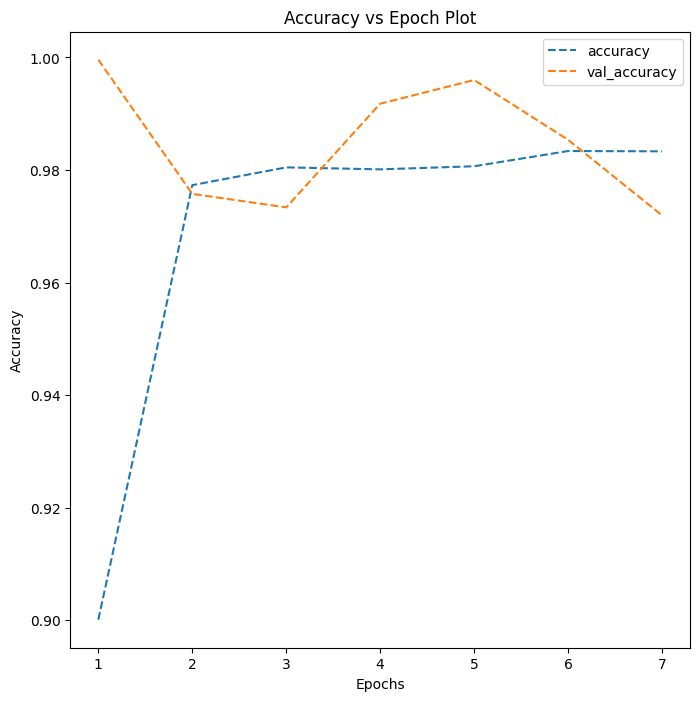

In [ ]:
accuracyPlot(model4_history)

<B>Plotting the classification report and confusion matrix

82/82 [==============================] - 0s 3ms/step
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      1300
           1       0.97      0.99      0.98      1300

    accuracy                           0.98      2600
   macro avg       0.98      0.98      0.98      2600
weighted avg       0.98      0.98      0.98      2600



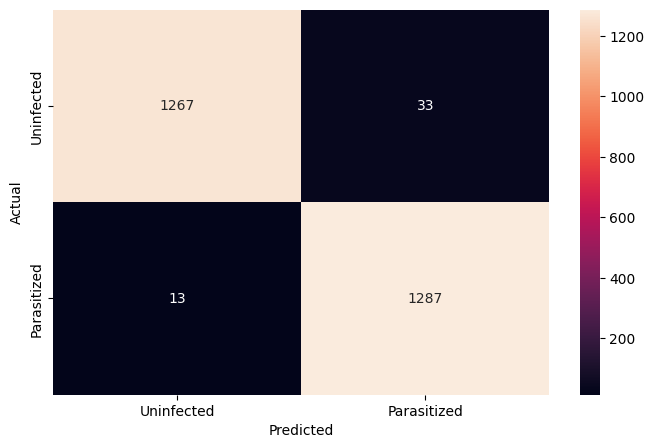

In [ ]:
predicted_model4 = model4.predict(test_data["images"])
printMetrics(test_data["labels"], predicted_model4)

This model seems to have the highest accuracy and with the lowest misclassifications for parasitized images. 

## **MODEL5 - Using the Pre-trained model (VGG16)**


In [ ]:
# Clear Keras backend
softreset()

In [ ]:
# Summary of the whole model
model = VGG16(weights='imagenet')
model.summary()

553467096/553467096 [==============================] - 25s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

<b>Compiling the model

In [ ]:
# Getting only the conv layers for transfer learning
transfer_layer = model.get_layer('block5_pool')
# Tried using different layers as the starting point with no satisfactory results
#transfer_layer = model.get_layer('block3_pool')

vgg_model = VGG16(weights='imagenet', include_top = False, input_shape = (64,64,3))
vgg_model.summary()

# Making all the layers of the VGG model non-trainable. i.e. freezing them
vgg_model.trainable = False

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 64, 64, 3)]       0         
                                                                 
 block1_conv1 (Conv2D)       (None, 64, 64, 64)        1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 64, 64, 64)        36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 32, 32, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 32, 32, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 32, 32, 128)       147584    
                                                              

In [ ]:
def model5():
  model = Sequential()

  # Adding the convolutional part of the VGG16 model from above
  model.add(vgg_model)

  # Flattening the output of the VGG16 model because it is from a convolutional layer
  model.add(Flatten())

  # Adding a dense output layer
  model.add(Dense(64, activation='relu'))
  model.add(Dropout(0.3))

  model.add(Dense(64, activation='relu'))
  model.add(BatchNormalization())

  model.add(Dense(2, activation='softmax'))

  return model

model5 = model5()
model5.summary()
model5.compile(loss = "categorical_crossentropy", optimizer = Adam(learning_rate = 0.001), metrics = ['accuracy'])


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 2, 2, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_6 (Dense)             (None, 64)                131136    
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_7 (Dense)             (None, 64)                4160      
                                                                 
 batch_normalization_2 (Batc  (None, 64)               256       
 hNormalization)                                                 
                                                      

<b> Using callbacks

In [ ]:
callbacks = [EarlyStopping(monitor = 'val_loss', patience = 2),
             ModelCheckpoint('.mdl_wts.hdf5', monitor = 'val_loss', save_best_only = True)]

<b>Fit and Train the model

In [ ]:
model5_history = model5.fit(train_data["images"], train_data["labels"], batch_size = 64, callbacks = callbacks, 
                    validation_split = 0.2, epochs = 10, verbose = 1)

Epoch 1/10
312/312 [==============================] - 14s 40ms/step - loss: 0.3070 - accuracy: 0.8687 - val_loss: 0.2813 - val_accuracy: 0.8938
Epoch 2/10
312/312 [==============================] - 11s 36ms/step - loss: 0.2049 - accuracy: 0.9189 - val_loss: 0.1745 - val_accuracy: 0.9291
Epoch 3/10
312/312 [==============================] - 10s 33ms/step - loss: 0.1892 - accuracy: 0.9229 - val_loss: 0.1303 - val_accuracy: 0.9762
Epoch 4/10
312/312 [==============================] - 10s 32ms/step - loss: 0.1714 - accuracy: 0.9320 - val_loss: 0.2408 - val_accuracy: 0.9179
Epoch 5/10
312/312 [==============================] - 10s 32ms/step - loss: 0.1665 - accuracy: 0.9346 - val_loss: 0.1822 - val_accuracy: 0.9513


<b>Plot the train and validation accuracy

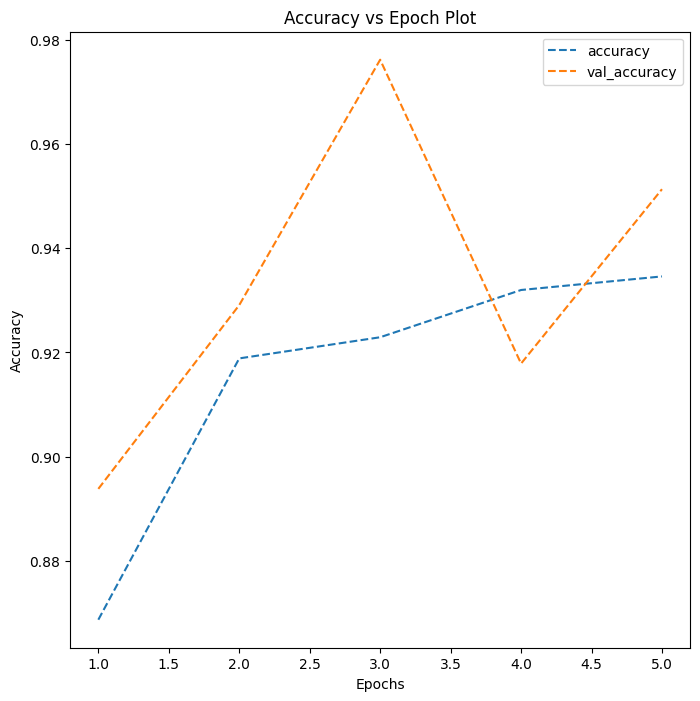

In [ ]:
accuracyPlot(model5_history)

Although the accuracy increased for the training data, the validation accuracy is very erratic. This behavior does not change much with fewer layers in the model with an attempt to reduce it's complexity. Overall, the performance on validation data is concerning despite a fairly decent accuracy.

<b> Evaluating the model

In [ ]:
accuracy5 = model5.evaluate(test_data["images"], test_data["labels"],  verbose = 1)
print('Model 5 Accuracy on test data: ', accuracy5[1])

82/82 [==============================] - 2s 20ms/step - loss: 0.1789 - accuracy: 0.9381
Model 5 Accuracy on test data:  0.938076913356781


<b>Plotting the classification report and confusion matrix

82/82 [==============================] - 1s 14ms/step
              precision    recall  f1-score   support

           0       0.96      0.91      0.94      1300
           1       0.92      0.96      0.94      1300

    accuracy                           0.94      2600
   macro avg       0.94      0.94      0.94      2600
weighted avg       0.94      0.94      0.94      2600



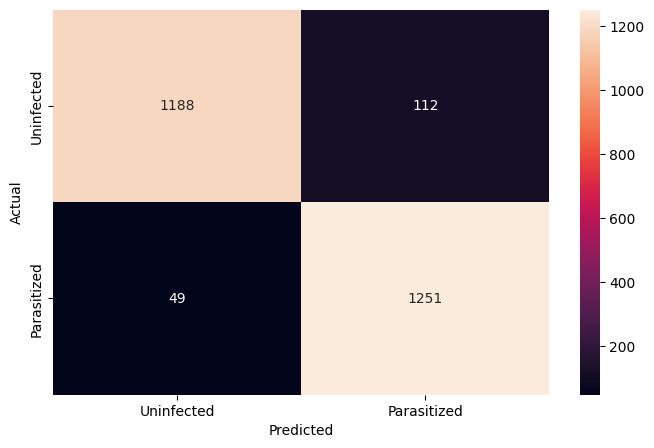

In [ ]:
predicted_model5 = model5.predict(test_data["images"])
printMetrics(test_data["labels"], predicted_model5)

## Model Comparison and Selection of Final model


In [ ]:
# Print the accuracies of the predictions of the 5 models on the test data
modelsAccuracies()

Model Details                                              Accuracy
-------------------------------------------------------  ----------
Model1: Base Model                                         0.978077
Model2: With more Convolutions, Dropouts and relu          0.977308
Model3: With Batch Normalization and LeakyRelu             0.908846
Model4: With Data Augmentation                             0.982308
Model5: Using transfer learning Pre-trained VGG16 model    0.938077


The model with the Data Augmentation outperformed the rest in most combinations of the parameters and will be the final model based on accuracy and least number of misclassifications for the parasitized images(only 11 were incorrectly labeled as uninfected). 

LeakyRelu did not seem to outperform the 'relu' activation function overall on this dataset. Batch normalization was also producing inconsistent results each time. The validation accuracy was not portraying a good performance of those models. The VGG16 model did not produce reliable results, as depicted by the validation accuracy. There might be other transfer learning models that are better suited to the current problem than the VGG16 model chosen here. 

I chose not to build a model against the HSV images as although it is a different image representation it seemed to have a lot more noise than the original RGB images. 




## Executive Summary

Overall, CNNs provided decent predictions for learning the intricacies of images and classifying them based on their differences. 


*   The dataset used for this project was well balanced, providing the models with parasitized (12582-training and 1300-test) and uninfected (12376-training and 1300-test) cells images to learn from.
*   While most of the infections seemed to appear on the periphery of the cells, they could be located anywhere. Data augmentation seemed to have helped with accuracy due to this reason by making more data available with multiple images with different locations of the infections. 
*   Trying several CNN architectures is resource intensive. Identifying a transfer learning model that better fits the infected malaria cells' data might be worth the effort to achieve higher accuracy. The VGG16 model may have had too many features learned by the convolution layers that were not useful for this problem.
*   All the models required GPUs to complete in a decent amount of time within the constraints of a free Google Colab. 
*   The final model chosen has three convolution layers to progressively learn the features and two layers before the output layer to reduce the number of parameters before classification using max pooling and batch normalization at each layer. The architecture also includes drop-outs to prevent overfitting. The model generated 584,050 parameters, 583,922 of which were trainable.






## Problem Solution Summary

Almost 50% of the world’s population is still in danger of contracting malaria. In 2019 alone, CDC reported more than 229 million malaria cases, of which 400,000 resulted in death. 67% of these cases were children. One of the integral steps to diagnosing this deadly infection is classifying the images of the red blood cells of the patients as parasitized or uninfected.

Diagnosis in the laboratory depends heavily on human expertise and is time-consuming. Accuracy is also affected by variability in manual classification. An efficiently built computer vision model to do the same could provide quicker and better results to help with early detection and treatment.

Convolutional Neural Networks are still the best technology available to classify images. Several entities have also performed research on the topic. The model using data augmentation to supplement the cell images from the dataset performed the best among the other builds built as part of this project. This model could effectively classify 2600 unseen images in a few minutes as parasitized or uninfected with 98.23% accuracy and only 11 misclassifications for parasitized cells images.

## Recommendations for implementation

Below are a few actionable items and some challenges with  suggestions for mitigating them:

* <b>Address technical limitations:</b> I built all models within the constraints of free access to Google Colab. Implementing several CNN architectures can require significant computational resources, including processing power, memory, and storage. The pricing plan for Google Colab might be worth reviewing as computing needs grow. The need for high-performance computing resources could be a limitation in resource-constrained settings, such as rural areas with limited access to electricity and internet connectivity, making deploying and maintaining these  models challenging. 

* <b>Fine-tuning the data augmentation model</b> could further improve accuracy beyond 98.23%. GridSearch or another technique could be used for hyperparameter optimization to identify the ideal learning rate, dropout rate, epochs, the number of neurons, etc. More resources and parallel processing could help achieve better reliability along with speed. The current model alone can classify 2600 images in under 5 minutes, which is faster manual classification. Researching other existing pre-trained transfer learning models</b> potentially better suited to this kind of data might be worth the time and effort, eliminating the resources needed for feature learning with potentially better results. <a href="https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8210472/">Multi-stage malaria parasite recognition by deep learning</a>

* <b>Limited and biased data:</b> Machine learning models require a large and diverse dataset for training to achieve accurate results. However, access to high-quality, diverse, and balanced datasets can be challenging due to limited availability, especially in resource-constrained areas where malaria is prevalent. Additionally, there may be biases in the data, such as differences in data collection practices, data quality, and demographic representation, which can impact the performance and generalization of the machine learning model. Leaning on hospitals/healthcare industry stakeholders to get access to more high-quality data for the models to learn from can lead to more reliable and effective modeling. <a href="https://news.mit.edu/2015/liver-cells-from-stem-cells-test-malaria-drugs-0205>">A new source of cells for modeling malaria</a>

* <b>Interpretability and explainability: </b>Deep learning models, are complex and difficult to interpret. This lack of interpretability and explainability can be a challenge when it comes to gaining trust and acceptance from healthcare providers and patients. It may be difficult to explain how and why the model arrived at a particular prediction, which can impact its adoption in clinical practice where interpretability and explainability are crucial.

* <b>Generalization to new settings:</b> Malaria is a disease that can have varying epidemiological characteristics in different regions, such as different species of malaria parasites, varying levels of drug resistance, and differences in vector populations. Machine learning models trained on data from one region or setting may not necessarily generalize well to other regions or settings, which can affect the accuracy and reliability of the model's predictions. Careful consideration needs to be given to the generalizability of the model across different populations and settings.

* <b>Regulatory and validation requirements: </b>Malaria detection using machine learning models may require regulatory approval and validation to ensure their accuracy, safety, and effectiveness. Meeting regulatory requirements, such as obtaining approvals from relevant authorities and complying with applicable regulations, can be time-consuming and costly. Patient data used for training and testing the machine learning model must be handled in compliance with ethical and legal standards to protect the privacy and confidentiality of patients. Ensuring that appropriate consent is obtained for data collection and use is important to maintain ethical standards.

While machine learning models offer promising opportunities for malaria detection, careful consideration of data quality, generalizability, interpretability, ethical considerations, computational resources, regulatory requirements, and human expertise is essential to ensure the accuracy, safety, and effectiveness of the models.